<a href="https://colab.research.google.com/github/anajikadam17/Google-Colab/blob/main/NLP/IMDB_Sentiment_Analysis_tfidf_NB_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import OS for navigation and environment set up
import os
# Complete path to storage location of the .zip file of data
zip_path = '/content/drive/MyDrive/Colab/NLP/Data/archive.zip'

os.chdir("/content/drive/MyDrive/Colab/NLP/Data/")
os.getcwd()
# Copy the .zip file into the present directory
!cp '{zip_path}' .
# Unzip quietly 
!unzip -q 'archive.zip'
# View the unzipped contents in the virtual machine
os.listdir()

cp: '/content/drive/MyDrive/Colab/NLP/Data/archive.zip' and './archive.zip' are the same file


['archive.zip',
 'UpdatedResumeDataSet.csv',
 'metamorphosis_clean.txt',
 'apps.csv',
 'reviews.csv',
 'hotel-reviews.csv',
 'reddit_vm.csv',
 'Test.csv',
 'Train.csv',
 'Valid.csv']

In [ ]:
path = "/content/drive/MyDrive/Colab/NLP/Data/IMDB dataset/"

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
import string
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#Lemmatization
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Load Data
def load_data(path,file):
    data = pd.read_csv(path+file)
    return data

In [ ]:

train_file = 'Train.csv'
train_data = load_data(path,train_file)

valid_file = 'Valid.csv'
valid_data = load_data(path,valid_file)

test_file = 'Test.csv'
test_data = load_data(path,test_file)

In [ ]:
train_data.shape, test_data.shape, valid_data.shape

((40000, 2), (5000, 2), (5000, 2))

In [ ]:
train_data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
#  Data Exploration
# Statistics and details
print('Columns:',train_data.columns)
print("------"*10)
print('Shape:', train_data.shape)
print("------"*10)
print('Stats:',train_data.describe(include='object'))
print("------"*10)
print('Class Distribution:',train_data['label'].value_counts())
print("------"*10)
print('Info:',train_data.info())
print("------"*10)

Columns: Index(['text', 'label'], dtype='object')
------------------------------------------------------------
Shape: (40000, 2)
------------------------------------------------------------
Stats:                                                      text
count                                               40000
unique                                              39723
top     Loved today's show!!! It was a variety and not...
freq                                                    4
------------------------------------------------------------
Class Distribution: 0    20019
1    19981
Name: label, dtype: int64
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB
Info: None
--------

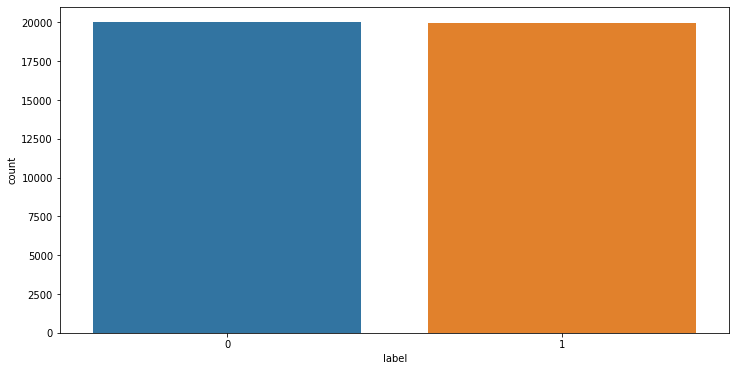

In [ ]:
#Class distribution
plt.figure(figsize=(12,6))
sns.countplot(x='label',data=train_data)

In [ ]:
#Get word count
train_data['word_count']=train_data['text'].str.lower().str.len()
train_data

,text,label,word_count
0,I grew up (b. 1965) watching and loving the Th...,0,874
1,"When I put this movie in my DVD player, and sa...",0,1811
2,Why do people who do not know what a particula...,0,983
3,Even though I have great interest in Biblical ...,0,351
4,Im a die hard Dads Army fan and nothing will e...,1,983
...,...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1,3111
39996,This movie is an incredible piece of work. It ...,1,291
39997,My wife and I watched this movie because we pl...,0,1092
39998,"When I first watched Flatliners, I was amazed....",1,1045


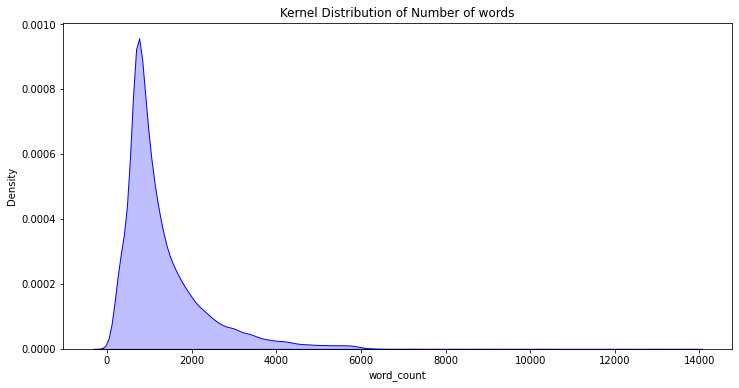

In [ ]:
plt.figure(figsize=(12,6))
sns.kdeplot( train_data['word_count'], shade=True, color='b')
plt.title('Kernel Distribution of Number of words')
plt.show()

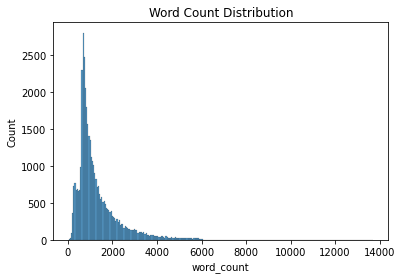

In [ ]:
#sns.histplot(train_data['word_count'],color='r')
sns.histplot(data=train_data, x="word_count")
plt.title('Word Count Distribution')
plt.show()

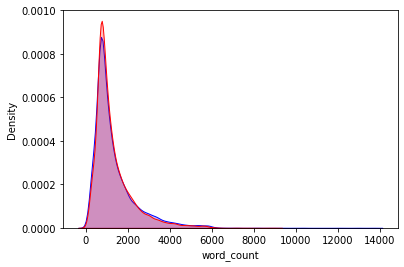

In [ ]:
positive_wordcnt =  train_data['word_count'][train_data['label']==1]
pos_plot = sns.kdeplot(positive_wordcnt,color='b',shade=True)
negative_wordcnt = train_data['word_count'][train_data['label']==0]
neg_plot = sns.kdeplot(negative_wordcnt,color='r',shade=True)

In [ ]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
# Remove stopwords
def preprocess_text(data):
    stop = stopwords.words('english')
    punct = '''!"#$%&'()*+,-/:;<=>?@[\]^_`{|}~'''
    #print(stop)
    #Make lower
    data['text'] = data['text'].str.lower()
    #Remove stopwords
    data['text'] = data['text'].apply(lambda x:' '.join([words for words in x.split() if words not in stop]))
    #Remove punctuations
    data['text'] = data['text'].str.translate(str.maketrans('', '', punct))
    data['word_count'] = data['text'].str.split().str.len()
    return data
train_data = preprocess_text(train_data)
train_data.head()

,text,label,word_count
0,grew b. 1965 watching loving thunderbirds. mat...,0,87
1,put movie dvd player sat coke chips expectatio...,0,162
2,people know particular time past like feel nee...,0,99
3,even though great interest biblical movies bor...,0,33
4,im die hard dads army fan nothing ever change ...,1,109


In [ ]:
def pos_tag(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag,wordnet.NOUN)

In [ ]:
nltk.pos_tag(['good '])[0][1][0].upper()

'N'

In [ ]:
print(train_data.head())
print(train_data.shape)

                                                text  label  word_count
0  grew b. 1965 watching loving thunderbirds. mat...      0          87
1  put movie dvd player sat coke chips expectatio...      0         162
2  people know particular time past like feel nee...      0          99
3  even though great interest biblical movies bor...      0          33
4  im die hard dads army fan nothing ever change ...      1         109
(40000, 3)


In [ ]:
def lemmatize(data):
    lemmatizer=WordNetLemmatizer()
    data['text'] = data['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w,pos_tag(w)) for w in word_tokenize(x)]))
    return data

In [ ]:
## Normalization;Lemmatization; No change as no pos_tag is there;hence add pos_tag
train_data = lemmatize(train_data)
train_data

,text,label,word_count
0,grow b . 1965 watch love thunderbird . mate sc...,0,87
1,put movie dvd player sat coke chip expectation...,0,162
2,people know particular time past like feel nee...,0,99
3,even though great interest biblical movie bore...,0,33
4,im die hard dad army fan nothing ever change t...,1,109
...,...,...,...
39995,western union something forgotten classic west...,1,300
39996,movie incredible piece work . explores every n...,1,28
39997,wife watch movie plan visit sicily stromboli s...,0,105
39998,first watch flatliners amaze . necessary featu...,1,96


In [ ]:
max_count = max(train_data['word_count'])
print(max_count)

1471


In [ ]:
# view one lemmatized record
train_data['text'][0]

'grow b . 1965 watch love thunderbird . mate school watch . played thunderbird school lunch school . want virgil scott . one want alan . counting 5 become art form . take child see movie hop would get glimpse love child . bitterly disappoint . high point snappy theme tune . could compare original score thunderbird . thankfully early saturday morning one television channel still play rerun series gerry anderson wife create . jonatha frakes hand director chair version completely hopeless . waste film . utter rubbish . cgi remake may acceptable replace marionette homo sapiens subsp . sapiens huge error judgment .'

In [ ]:
## Plotting word cloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(40,30))
    plt.imshow(wordcloud)

In [ ]:
#get postive and negative sentiment records for wordcloud
positive = train_data['text'][train_data['label']==1]
negative = train_data['text'][train_data['label']==0]
stop = set(stopwords.words('english'))
stop.update(["br", "href","film","movie","one"])
print(stop)


{'being', 'until', 'off', 'its', 'is', 're', 'am', 'no', 'in', 'there', 'most', 'some', 'own', 'll', 'them', 'isn', 'here', 'wouldn', 'because', 'you', 'such', 'one', "needn't", 'few', "mightn't", "you've", 'himself', 'was', 'by', 'does', 'me', "you'll", 'from', 'any', "haven't", 'hadn', 'ours', 'after', 'we', 'with', 't', 'and', "isn't", 'shan', "she's", 'do', 'very', 'd', 'when', 'have', 'haven', 'again', 'ourselves', 'they', 'just', 'her', 'm', "should've", 'your', 'yours', "weren't", 'what', 'don', 'be', 'a', 'href', 'myself', 'he', 'his', 'about', 'him', 'that', 'further', 'doesn', 'doing', 'ma', "won't", 'were', 'did', 'more', "doesn't", 'weren', 'herself', 'has', 'not', 'it', 'didn', 'why', 'of', 'having', 'the', 'their', 'but', 'to', 'should', 'are', 'these', 'i', 'wasn', 'been', 'both', 'out', 'once', "wasn't", 'needn', 'over', 'other', 'below', 'will', 'ain', "that'll", 'all', 'y', 'up', 'which', 'under', 'now', 'only', 'theirs', 'while', 've', 'our', 'can', 'against', 'whom'

In [ ]:
#negative
## Wordcloud
pos_wordcloud = WordCloud(stopwords=stop).generate(' '.join(positive))
neg_wordcloud = WordCloud(stopwords=stop).generate(' '.join(negative))
# pos_wordcloud = WordCloud(stopwords=stop,width=800,height=800,min_font_size=10).generate(' '.join(positive))
# neg_wordcloud = WordCloud(stopwords=stop,width=800,height=800,min_font_size=10).generate(' '.join(negative))

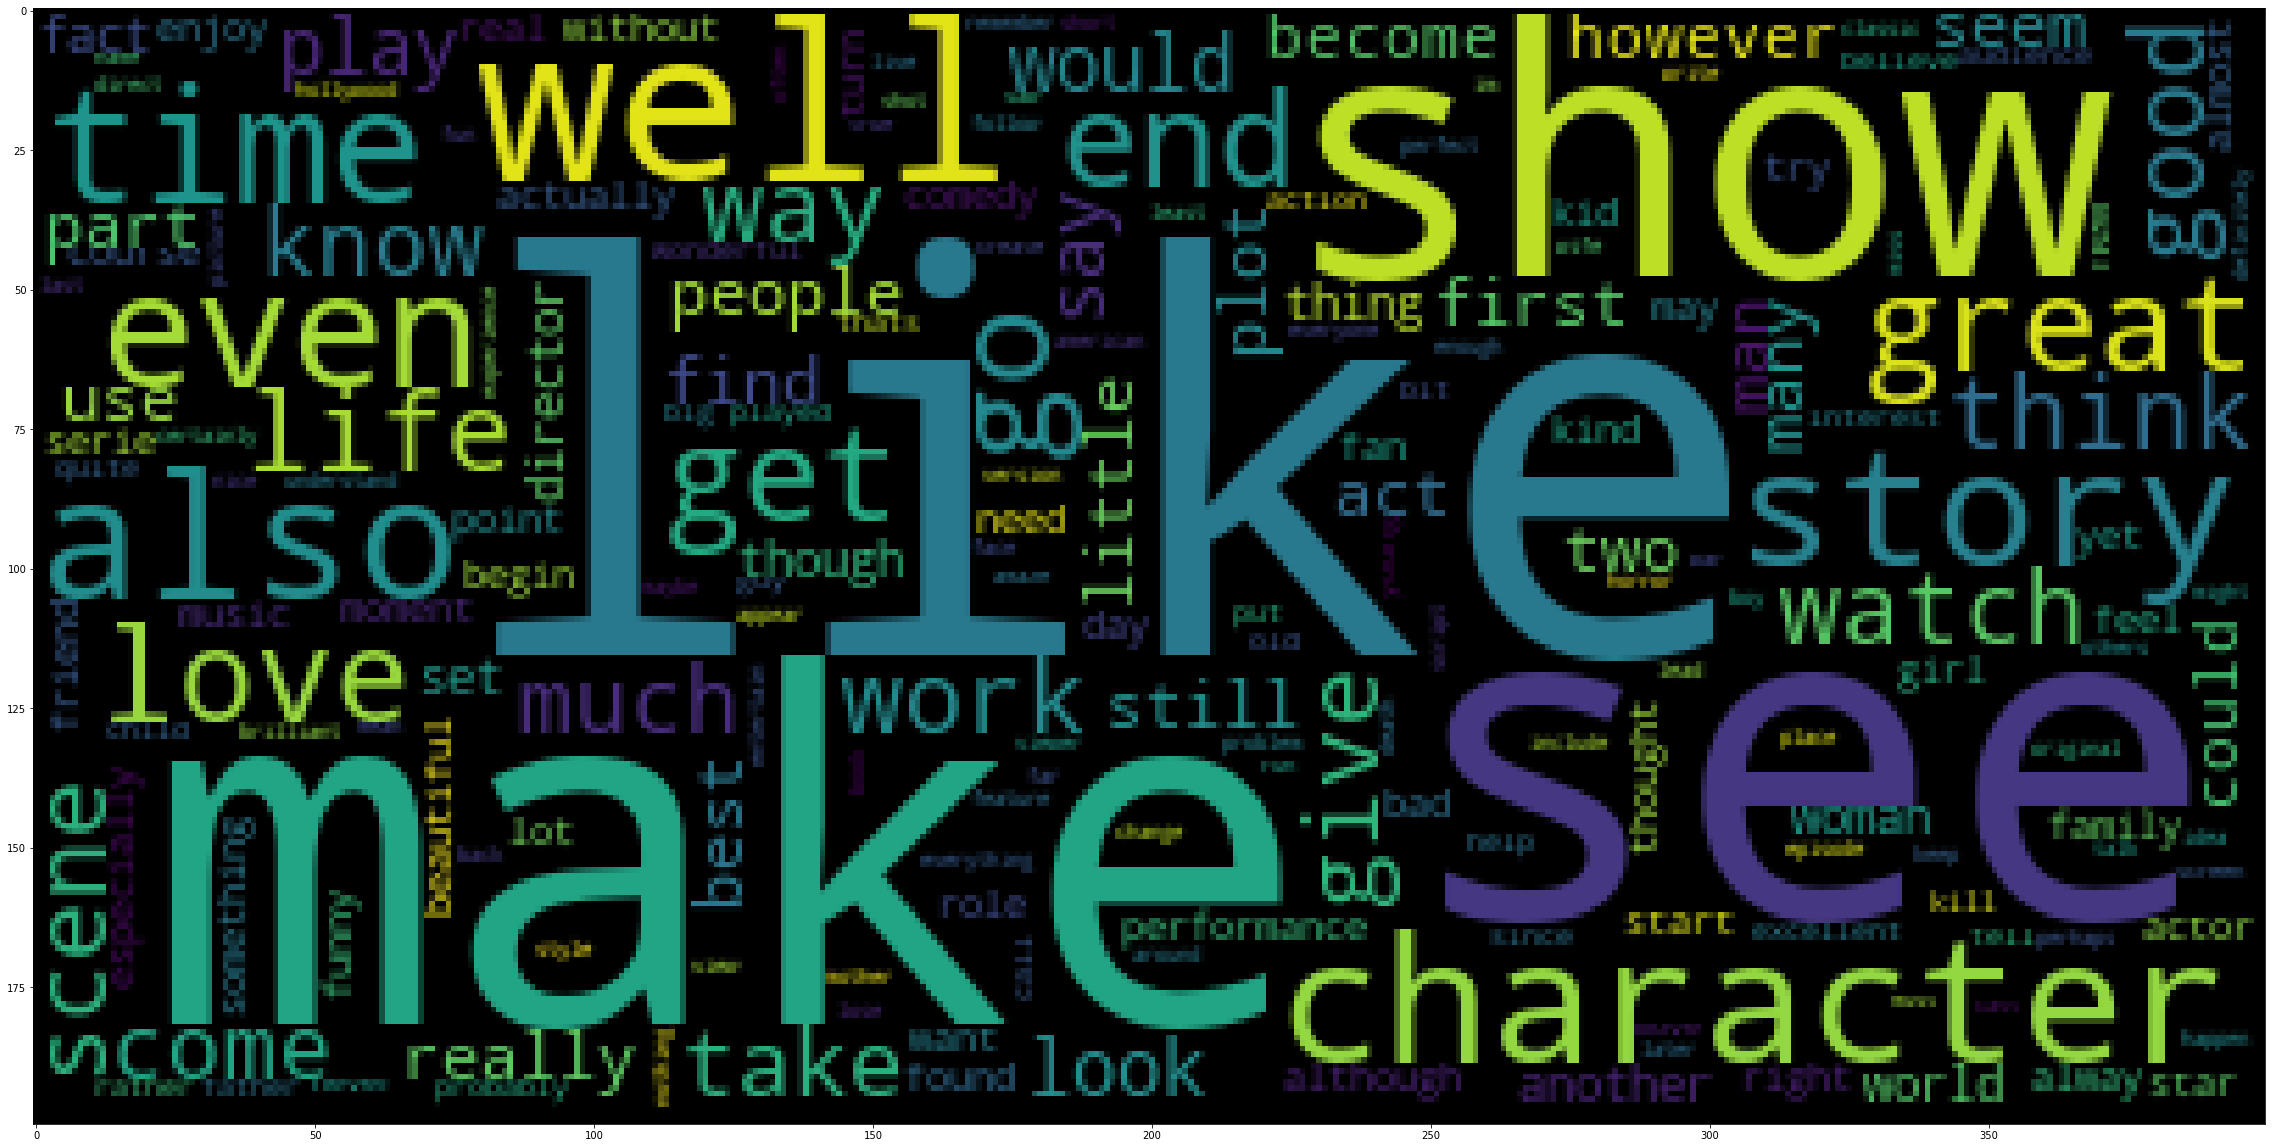

In [ ]:
plot_cloud(pos_wordcloud)

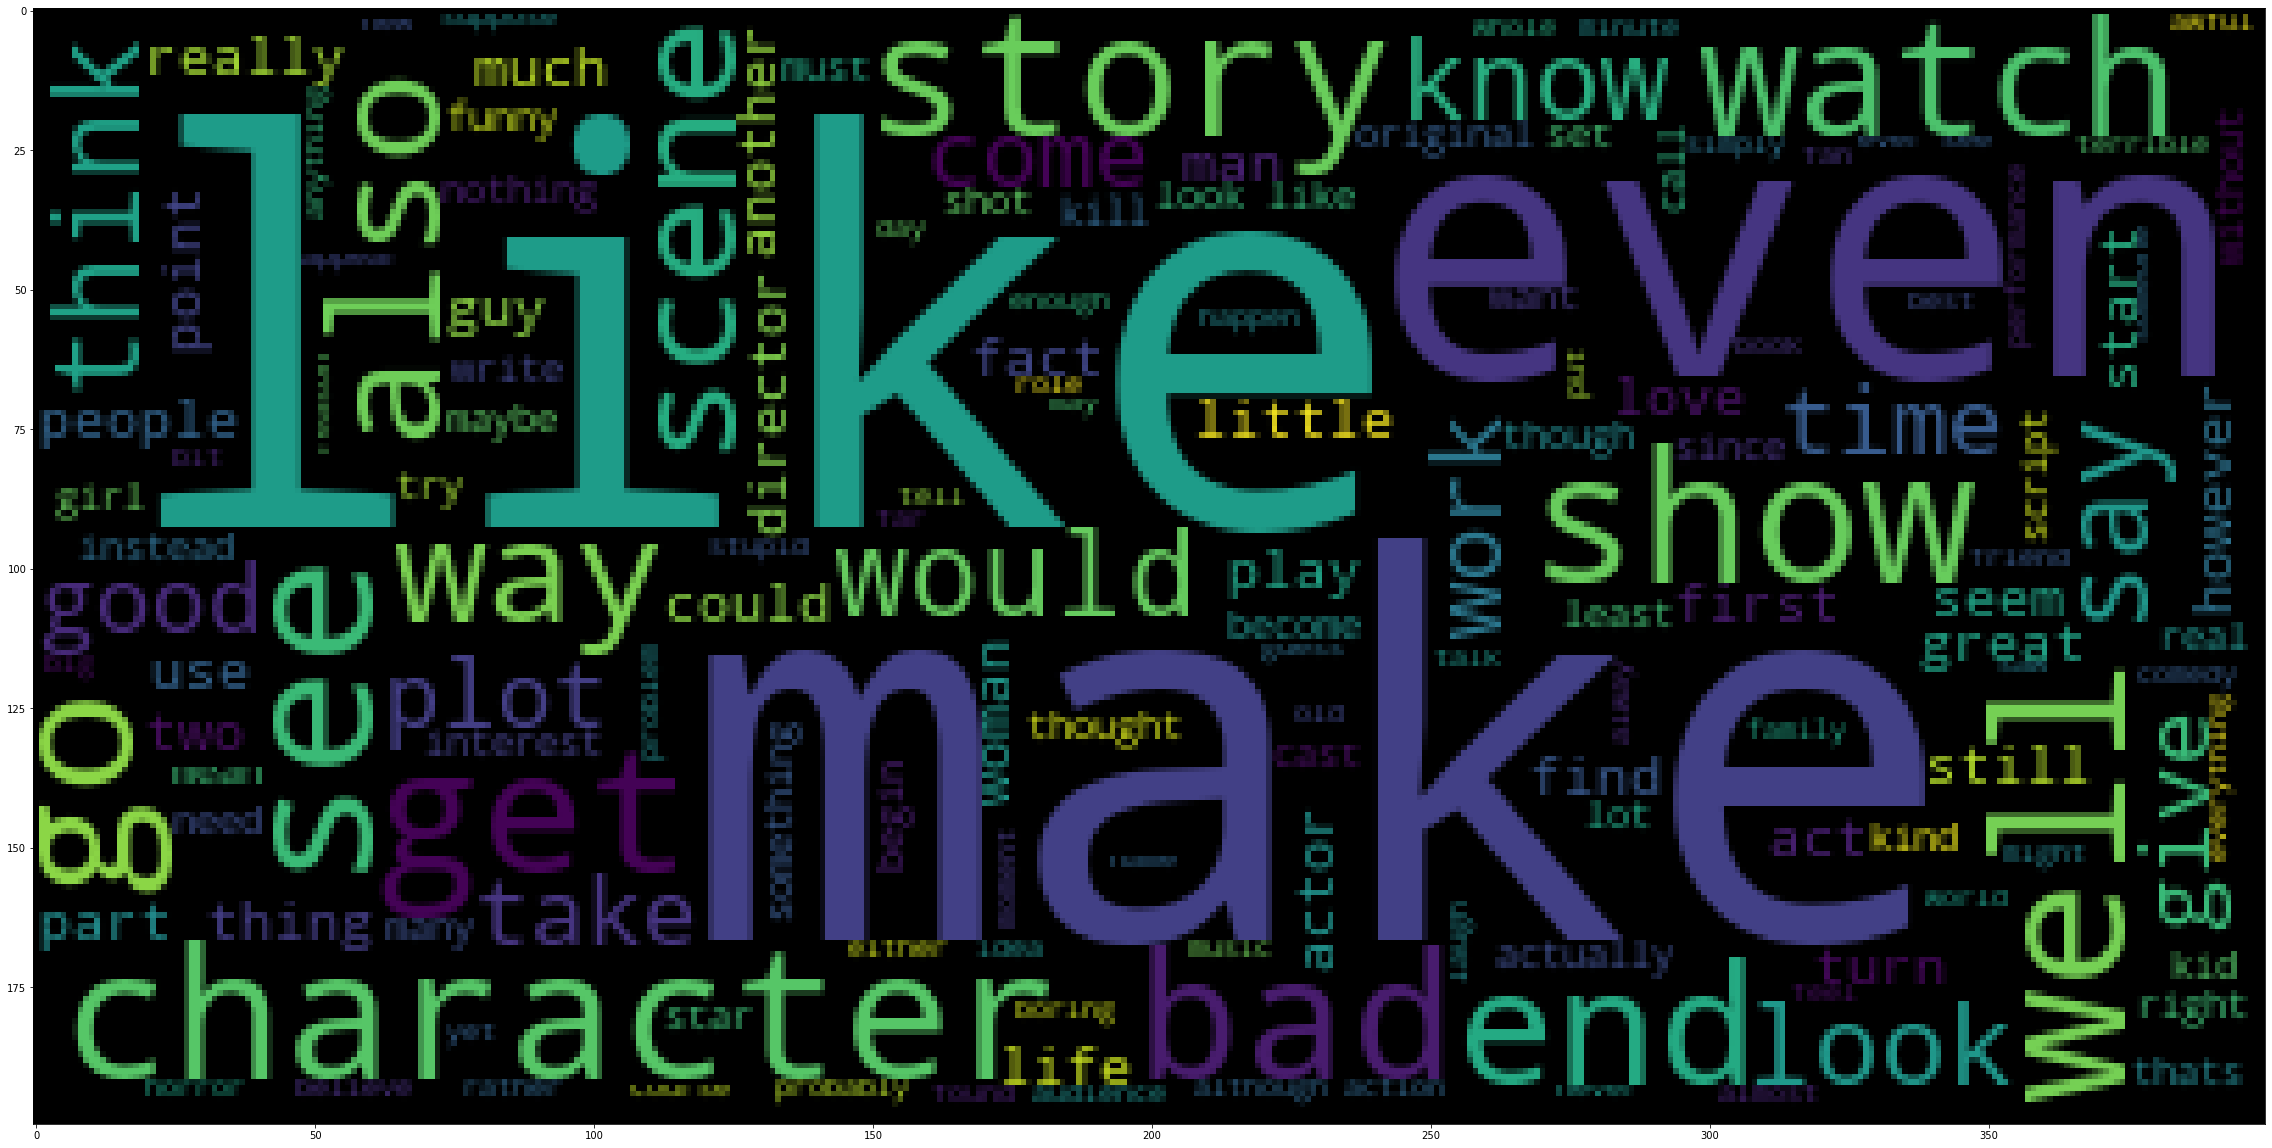

In [ ]:
plot_cloud(neg_wordcloud)

In [ ]:
#Remove word_count column
train_data = train_data[['text','label']]
train_data

,text,label
0,grow b . 1965 watch love thunderbird . mate sc...,0
1,put movie dvd player sat coke chip expectation...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movie bore...,0
4,im die hard dad army fan nothing ever change t...,1
...,...,...
39995,western union something forgotten classic west...,1
39996,movie incredible piece work . explores every n...,1
39997,wife watch movie plan visit sicily stromboli s...,0
39998,first watch flatliners amaze . necessary featu...,1


In [ ]:
#  Do pre-processing for test and valid dataset
valid_data = preprocess_text(valid_data)
valid_data = lemmatize(valid_data)

test_data = preprocess_text(test_data)
test_data = lemmatize(test_data)
test_data

,text,label,word_count
0,always write series complete stinkfest jim bel...,0,205
1,1st watch 1272002 3 10dirsteve purcell typical...,0,96
2,movie poorly write direct fell asleep 30 minut...,0,116
3,interest thing miryang secret sunshine actor ....,1,409
4,first read berlin meer expect much . thought r...,0,95
...,...,...,...
4995,kind picture john lassiter would make today ad...,1,55
4996,must see saw whip press screen hilarious . be ...,1,92
4997,nbc ashamed . allow child see this . definitel...,0,64
4998,movie clumsy mishmash various ghoststory suspe...,0,71


In [ ]:
x_valid_data = valid_data[['text']]
y_valid_data = valid_data[['label']]

x_test_data = test_data[['text']]
y_test_data = test_data[['label']]

In [ ]:
#  Building model
# Word technique
#Create feature vectors using Bag of Words-TfIdf
tfidf_converter = TfidfVectorizer(max_features=1000,min_df=5,max_df=0.7)
x = tfidf_converter.fit_transform(train_data['text']).toarray()
y = train_data['label']

In [ ]:
#bi-grams
# Word technique
#Create feature vectors using Bag of Words-TfIdf
ntfidf_converter = TfidfVectorizer(max_features=1000,min_df=5,max_df=0.7,ngram_range=(2,2))
nx = ntfidf_converter.fit_transform(train_data['text']).toarray()
ny = train_data['label']

In [ ]:
print(x.shape)
print(y)

(40000, 1000)
0        0
1        0
2        0
3        0
4        1
        ..
39995    1
39996    1
39997    0
39998    1
39999    1
Name: label, Length: 40000, dtype: int64


In [ ]:
y_valid_data.shape

(5000, 1)

In [ ]:
y_valid=np.array(y_valid_data).reshape(-1,1)
print(y_valid)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


## GaussianNB

In [ ]:
# Choose model
#Naive Bayes Algorithm p(sent|word) = p(sent)p(word|sent)/p(word)
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
gnb = GaussianNB()
gnb.fit(x,y)


ngram_gnb = GaussianNB()
ngram_gnb.fit(nx,ny)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
#Save model
import pickle
gnb_model = pickle.dumps(gnb)

ngram_gnb_model = pickle.dumps(ngram_gnb)

In [ ]:
path

'/content/drive/MyDrive/Colab/NLP/Data/IMDB dataset/'

In [ ]:
with open(path+'GaussianNB.pkl', 'wb') as fp:
  pickle.dump(gnb, fp)

with open(path+'GaussianNB_ngram.pkl', 'wb') as fl:
  pickle.dump(ngram_gnb, fl)

In [ ]:
with open(path+'GaussianNB.pkl', 'rb') as fp:
  gnb_model = pickle.load(fp)

with open(path+'GaussianNB_ngram.pkl', 'rb') as fl:
  ngram_gnb_model = pickle.load(fl)


In [ ]:
# Use tfidf to transform test and valid data
x_val_data = tfidf_converter.transform(x_valid_data['text']).toarray()
x_tst_data = tfidf_converter.transform(x_test_data['text']).toarray()

In [ ]:
#ngram
# Use tfidf to transform test and valid data
nx_valid_data = ntfidf_converter.transform(x_valid_data['text']).toarray()
nx_test_data = ntfidf_converter.transform(x_test_data['text']).toarray()

In [ ]:
# Predict valid
ypred_valid = gnb_model.predict(x_val_data)
#print(ypred_valid)
print('Valid Accuracy:',accuracy_score(y_valid_data,ypred_valid))

#Predict Test
ypred_test = gnb_model.predict(x_tst_data)
print('Test Accuracy:',accuracy_score(y_test_data,ypred_test))
print(confusion_matrix(y_test_data,ypred_test))
print('Classification Report:',classification_report(y_test_data,ypred_test))

Valid Accuracy: 0.7978
Test Accuracy: 0.8056
[[1990  505]
 [ 467 2038]]
Classification Report:               precision    recall  f1-score   support

           0       0.81      0.80      0.80      2495
           1       0.80      0.81      0.81      2505

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000



In [ ]:
#ngram
# Predict valid
nypred_valid = ngram_gnb_model.predict(nx_valid_data)
#print(ypred_valid)
print('Valid Accuracy:',accuracy_score(y_valid_data,nypred_valid))

#Predict Test
nypred_test = ngram_gnb_model.predict(nx_test_data)
print('Test Accuracy:',accuracy_score(y_test_data,nypred_test))
print(confusion_matrix(y_test_data,ypred_test))
print('Classification Report:',classification_report(y_test_data,nypred_test))

Valid Accuracy: 0.741
Test Accuracy: 0.7346
[[1990  505]
 [ 467 2038]]
Classification Report:               precision    recall  f1-score   support

           0       0.74      0.72      0.73      2495
           1       0.73      0.75      0.74      2505

    accuracy                           0.73      5000
   macro avg       0.73      0.73      0.73      5000
weighted avg       0.73      0.73      0.73      5000



In [ ]:
with open(path+'tfidf_converter.pkl', 'wb') as fin:
  pickle.dump(tfidf_converter, fin)

In [ ]:
with open(path+'tfidf_converter.pkl', 'rb') as fp:
  tfidf_converter = pickle.load(fp)

In [ ]:
#Random text prediction
text = ['that is too bad.but i can assure it can be made better'
        ,'not sure if the climax really did well'
        ,'as expected']
text = tfidf_converter.transform(text).toarray()
print(gnb_model.predict(text))

[0 0 1]


In [ ]:
#Random text prediction
text = ['that is not bad.but i can assure it can be made better'
        ,'not sure if the climax really did well'
        ,'as expected']
text = ntfidf_converter.transform(text).toarray()
print(ngram_gnb_model.predict(text))

[1 1 1]


## Random Forest

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=4, random_state=0)
rf.fit(x,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
with open(path+'RandomForestCl.pkl', 'wb') as fp:
  pickle.dump(rf, fp)

In [ ]:

# Use tfidf to transform test and valid data
x_rf_valid_data = tfidf_converter.transform(x_valid_data['text']).toarray()
x_rf_test_data = tfidf_converter.transform(x_test_data['text']).toarray()

In [ ]:
with open(path+'RandomForestCl.pkl', 'rb') as fp:
  #Load the model
  rf_model = pickle.load(fp)

In [ ]:
# Predict valid
ypred_valid = rf_model.predict(x_rf_valid_data)
#print(ypred_valid)
print('RF Valid Accuracy:',accuracy_score(y_valid_data,ypred_valid))

#Predict Test
ypred_test = rf_model.predict(x_rf_test_data)
print('RF Test Accuracy:',accuracy_score(y_test_data,ypred_test))

RF Valid Accuracy: 0.7948
RF Test Accuracy: 0.7896


In [ ]:
#Random text prediction
text = ['that is too bad.but i can assure it can be made better'
      ,'not sure if the climax really diid well']
text = tfidf_converter.transform(text).toarray()
print(rf_model.predict(text))

[0 1]


## Boosting

In [ ]:
#Boosting
import sklearn
print(sklearn.__version__)
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(x,y)

0.22.2.post1


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [ ]:
# Use tfidf to transform test and valid data
x_val_data = tfidf_converter.transform(x_valid_data['text']).toarray()
x_tst_data = tfidf_converter.transform(x_test_data['text']).toarray()

In [ ]:
#Save model
with open(path+'AdaBoostCl.pkl', 'wb') as fp:
  pickle.dump(ada, fp)

with open(path+'AdaBoostCl.pkl', 'rb') as fp:
  #Load the model
  ada_model = pickle.load(fp)


In [ ]:


#Predict valid and test data

y_ada_val_pred = ada_model.predict(x_val_data)
print("Valid data Accuracy is :",accuracy_score(y_valid_data,y_ada_val_pred))

#Predict Test
y_ada_tst_pred = ada_model.predict(x_tst_data)
print('Test Accuracy:',accuracy_score(y_test_data,y_ada_tst_pred))
print(confusion_matrix(y_test_data,y_ada_tst_pred))
print('Classification Report:',classification_report(y_test_data,y_ada_tst_pred))

Valid data Accuracy is : 0.8064
Test Accuracy: 0.8012
[[1955  540]
 [ 454 2051]]
Classification Report:               precision    recall  f1-score   support

           0       0.81      0.78      0.80      2495
           1       0.79      0.82      0.80      2505

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.80      0.80      5000



In [ ]:
#Random Text Prediction
text = ['not good'
        ,'worth watching'
        ,'bad'
        ,'grew up listening to this.awful']
text = tfidf_converter.transform(text).toarray()
print(gnb_model.predict(text))
print(rf_model.predict(text))
print(ada_model.predict(text))

[0 1 0 0]
[1 1 0 0]
[1 1 0 0]


In [ ]:
#Random text prediction
text = ['that is too bad.but i can assure it can be made better'
        ,'not sure if the climax really did well'
        ,'as expected']
text = tfidf_converter.transform(text).toarray()
print(ada_model.predict(text))

[0 1 1]
